RIght, so in this notebook we are going to investigating the feasibility of predicting household income band from smart meter data by training transformer neural networks on the IDEAL dataset.

In [2]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# load survey responses
survey = pd.read_csv('/Users/eoghan/repos/makemore/data/survey_responses.csv')

In [4]:
# which columns relate to income?
cols = survey.columns[survey.columns.str.contains('income')]
cols 

Index(['income_band_mid', 'income_change_initial',
       'incomeband_certainty_initial'],
      dtype='object')

In [5]:
# what are the unique values in income_band_mid 
survey['income_band_mid'].unique()

array([nan, '£43,200 to £48,599', '£48,600 to £53,999',
       '£54,000 to £65,999', '£13,500 to £16,199', '£27,000 to £32,399',
       '£32,400 to £37,799', '£66,000 to £77,999', 'less than £10,800'],
      dtype=object)

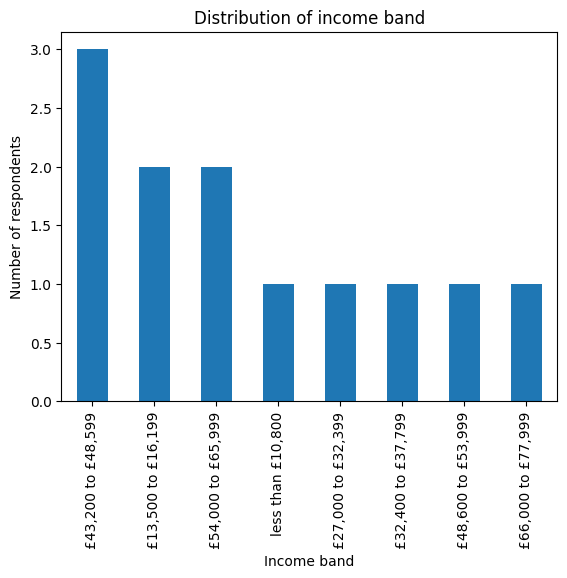

In [6]:
# we want to plot the distribution of income_band_mid, however we want to order the x-axis by the income_band_mid values
# we can do this by converting the income_band_mid column to a category and specifying the order of the categories
survey['income_band_mid_cat'] = survey['income_band_mid'].astype('category')
# the possible values are '£43,200 to £48,599', '£48,600 to £53,999',      '£54,000 to £65,999', '£13,500 to £16,199', '£27,000 to £32,399',        '£32,400 to £37,799', '£66,000 to £77,999', 'less than £10,800'
# we can specify the order of the categories as follows
survey['income_band_mid_cat'] = survey['income_band_mid_cat'].cat.reorder_categories(['less than £10,800', '£13,500 to £16,199', '£27,000 to £32,399', '£32,400 to £37,799', '£43,200 to £48,599', '£48,600 to £53,999', '£54,000 to £65,999', '£66,000 to £77,999'])
# now we can plot the distribution of income_band_mid
survey['income_band_mid_cat'].value_counts().plot(kind='bar')
plt.xlabel('Income band')
plt.ylabel('Number of respondents')
plt.title('Distribution of income band')
plt.show()

There's only 12 responses. That's not really enough to work with. 

In [7]:
# okay it was the wrong data file
survey = pd.read_csv('/Users/eoghan/repos/makemore/data/home.csv')
cols = survey.columns[survey.columns.str.contains('income')]
cols 

Index(['income_band', 'equivalised_income'], dtype='object')

In [8]:
# what are the unique values in income_band
survey['income_band'].unique()

array(['Missing', '£90,000 or more', '£48,600 to £53,999',
       '£43,200 to £48,599', '£66,000 to £77,999', '£54,000 to £65,999',
       '£27,000 to £32,399', 'less than £10,800', '£37,800 to £43,199',
       '£23,400 to £26,999', '£16,200 to £19,799', '£32,400 to £37,799',
       '£78,000 to £89,999', '£13,500 to £16,199', '£10,800 to £13,499',
       '£19,800 to £23,399'], dtype=object)

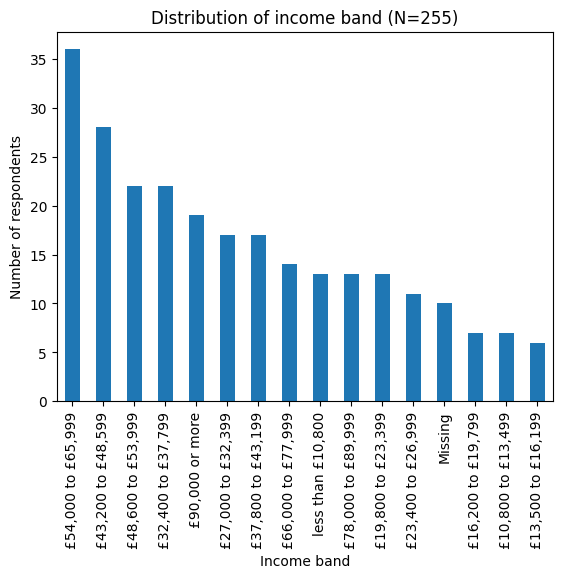

In [9]:
survey['income_band'].value_counts().plot(kind='bar')
plt.xlabel('Income band')
plt.ylabel('Number of respondents')
# what is the total number of non missing values in the income_band column?
total_responses = survey['income_band'].count()
plt.title('Distribution of income band (N={})'.format(total_responses))
plt.show()

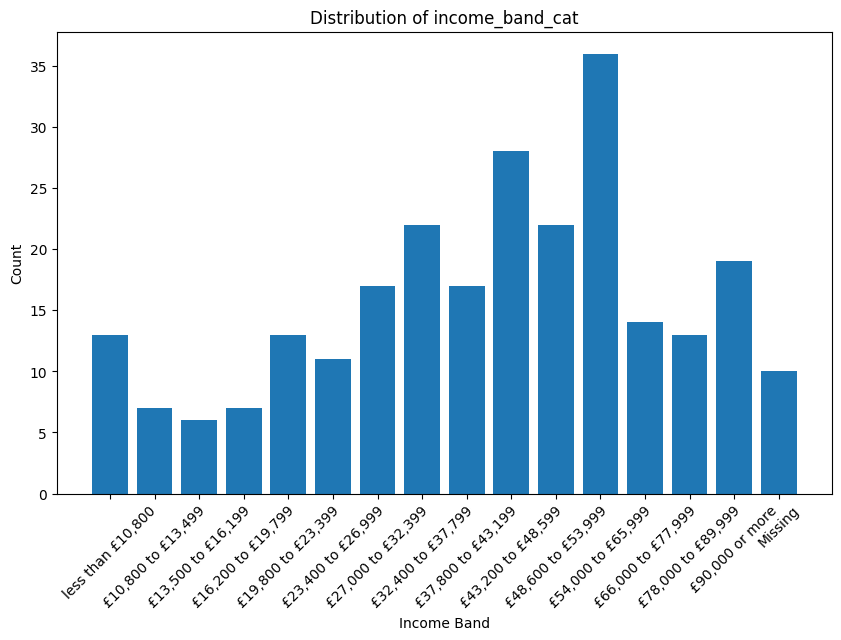

In [10]:
# let's plot this out but in order of the income bands
survey['income_band_cat'] = survey['income_band'].astype('category')
survey['income_band_cat'] = survey['income_band_cat'].cat.reorder_categories(['less than £10,800', '£10,800 to £13,499', '£13,500 to £16,199', '£16,200 to £19,799', '£19,800 to £23,399', '£23,400 to £26,999', '£27,000 to £32,399', '£32,400 to £37,799', '£37,800 to £43,199', '£43,200 to £48,599', '£48,600 to £53,999', '£54,000 to £65,999', '£66,000 to £77,999', '£78,000 to £89,999', '£90,000 or more','Missing'])
# now we want to plot the distribution of income_band_cat but keep the order of the categories
# Assuming df is your DataFrame and 'income_band_cat' is your categorical column
counts = survey['income_band_cat'].value_counts(sort=False)

plt.figure(figsize=(10,6))
plt.bar(counts.index, counts.values)
plt.title('Distribution of income_band_cat')
plt.xlabel('Income Band')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Add this line
plt.show()


Okay, so we've got 255 to work with. This is more like it. So this is going to be the target variable. the input variable(s) are going to be the same as used in the encoder-dual-decoder model. However let's just start with the most simple, and use electricity as the input.

## A binary classification into low income and high income
To make this classification problem easier we will transform the income band data into low and high income categories. Then this becomes a binary classification problem, which has advantages e.g. we can treat the low income category as the 'positive' indicator, as it's the classification that we want to identify, and we can start using evaluation metrics like precision, sensitivity (or recall). 

For the purposes here we will treat all income bands below the £19,800 threshold as low income.

In [11]:
# create a new column in the survey df called low_income which is True if the income_band is in the bottom four income bands
survey['low_income'] = survey['income_band_cat'].isin(['less than £10,800', '£10,800 to £13,499', '£13,500 to £16,199', '£16,200 to £19,799'])
# what proportion of the survey respondents are in the bottom four income bands?
print(survey['low_income'].mean())
# how many respondents are in the low income category and how many in the high income category?
survey['low_income'].value_counts()

0.12941176470588237


low_income
False    222
True      33
Name: count, dtype: int64

Okay, so about 13% of the households are low income, 33 in total. We are dealing with a situation with unbalanced categories, which makes metrics like accuracy unreliable. In this case the model could be 87% accurate but get all of the low income classifications incorrect. This is why metrics like precision, and recall are important.

In [12]:
# let's add a column to the survey df called 'low_income_str' which is 'Low income' if the respondent is in the low income category and 'High income' otherwise
survey['low_income_str'] = np.where(survey['low_income'], 'Low income', 'High income')

# Hyperparameters

In [14]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
import numpy as np


In [15]:

# hyperparameters
batch_size = 32 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 300
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 8 # embedding dimension
n_head = 1 # number of attention heads
n_layer_do = 1 # number of decoder only layers
# n_layer_ca = 1 # number of cross-attention layers
dropout = 0.1

torch.manual_seed(1338)

# Data preprocessing

In [16]:
# get the data
data = pd.read_csv('/Users/eoghan/repos/makemore/data/daily_demand_and_weather.csv')
# TODO: add <S> start of sequence token at each change of household_id, and align encoder context data with target, not input tokens
# to start, we will just work with the gas data, later we will complexify things by adding in electricity and weather, and information about the calender day
raw_gas = data['mean_rounded_gas_pulse'].copy()
raw_elec = data['mean_rounded_electric_combined'].copy()

# set all values less than 0 to 0
raw_gas.loc[raw_gas < 0] = 0
raw_elec.loc[raw_elec < 0] = 0

# set unreasonably high values to Nan
raw_gas.loc[raw_gas > 100000] = np.nan
raw_elec.loc[raw_elec > 100000] = np.nan

# so let's simplify the dataset, and round raw_gas to the nearest 10, just to reduce the size of our vocabulary. 
raw_gas = raw_gas.round(-1)
raw_elec = raw_elec.round(-1)

# first however we need to deal with missing values, in particular we need to replace any nan with a special character <M> which will represent missing values
raw_gas = raw_gas.astype(str).replace('nan', '<M>')
raw_elec = raw_elec.astype(str).replace('nan', '<M>')

#create a mapping from values to indices
unique_values_gas = raw_gas.unique()
vocab_size_gas = len(unique_values_gas)
unique_values_gas.sort()
vtoi_gas = {val:i for i, val in enumerate(unique_values_gas)}
itov_gas = {i:val for i, val in enumerate(unique_values_gas)}
encode_gas = lambda v: [vtoi_gas[val] for val in v] # take a list of values and return a list of indices
decode_gas = lambda l: [itov_gas[i] for i in l] # take a list of indices and return a list of values
data_gas = torch.tensor(encode_gas(raw_gas), dtype=torch.long)

# let's split the data into train and validation splits 0.9 / 0.1
#n = int(0.9*len(data_gas))
n = int(0.1*len(data_gas))
train_data_gas = data_gas[n:]
val_data_gas = data_gas[:n]

# and let's do the same for raw_elec
unique_values_elec = raw_elec.unique()
vocab_size_elec = len(unique_values_elec)
unique_values_elec.sort()
vtoi_elec = {val:i for i, val in enumerate(unique_values_elec)}
itov_elec = {i:val for i, val in enumerate(unique_values_elec)}
encode_elec = lambda v: [vtoi_elec[val] for val in v] # take a list of values and return a list of indices
decode_elec = lambda l: [itov_elec[i] for i in l] # take a list of indices and return a list of values
data_elec = torch.tensor(encode_elec(raw_elec), dtype=torch.long)
n = int(0.1*len(data_elec))
train_data_elec = data_elec[n:]
val_data_elec = data_elec[:n]

# add in contextual data, starting with the minimum temperature
# first we need to deal with missing values, in particular we need to replace any nan with a special character <M> which will represent missing values
data['mintemp'] = data['mintemp'].astype(str).replace('nan', '<M>')
unique_values_mintemp = data['mintemp'].unique()
vocab_size_mintemp = len(unique_values_mintemp)
unique_values_mintemp.sort()
vtoi_mintemp = {val:i for i, val in enumerate(unique_values_mintemp)}
itov_mintemp = {i:val for i, val in enumerate(unique_values_mintemp)}
encode_mintemp = lambda v: [vtoi_mintemp[val] for val in v] # take a list of values and return a list of indices
decode_mintemp = lambda l: [itov_mintemp[i] for i in l] # take a list of indices and return a list of values
data_mintemp = torch.tensor(encode_mintemp(data['mintemp']), dtype=torch.long)
n = int(0.1*len(data_mintemp))
train_data_mintemp = data_mintemp[n:]
val_data_mintemp = data_mintemp[:n]


In [17]:
# now we need to create the array of income data
# we want to join the two dataframes on household_id for data and homeid for survey
# we will use the household_id from the data dataframe
# we will use the homeid from the survey dataframe
# we will use the income_band from the survey dataframe, and the low income classification too
joined = data.merge(survey[['homeid','income_band_cat','low_income_str']], left_on='household_id', right_on='homeid')
# let's check that the join worked
joined.head()

,household_id,datetime,maxtemp,mintemp,conditions,day_of_week,is_weekend,is_bank_holiday,mean_rounded_gas_pulse,mean_rounded_electric_combined,homeid,income_band_cat,low_income_str
0,100,2017-03-07,10.0,4.0,Chance of Rain,1.0,False,False,5277.0,343.0,100,"£27,000 to £32,399",High income
1,100,2017-03-08,11.0,5.0,Chance of Rain,2.0,False,False,6832.0,253.0,100,"£27,000 to £32,399",High income
2,100,2017-03-09,11.0,3.0,Chance of Rain,3.0,False,False,1283.0,203.0,100,"£27,000 to £32,399",High income
3,100,2017-03-10,10.0,7.0,Overcast,4.0,False,False,4168.0,222.0,100,"£27,000 to £32,399",High income
4,100,2017-03-11,13.0,6.0,Chance of Rain,5.0,True,False,1264.0,243.0,100,"£27,000 to £32,399",High income


In [18]:
# now we create a torch tensor of the low income data similar to the other data arrays
raw_income = joined['low_income_str'].copy()
unique_values_income = raw_income.unique()
vocab_size_income = len(unique_values_income)
vtoi_income = {val:i for i, val in enumerate(unique_values_income)}
itov_income = {i:val for i, val in enumerate(unique_values_income)}
encode_income = lambda v: [vtoi_income[val] for val in v] # take a list of values and return a list of indices
decode_income = lambda l: [itov_income[i] for i in l] # take a list of indices and return a list of values
data_income = torch.tensor(encode_income(raw_income), dtype=torch.long)

In [31]:
# we want to check that low income is encoded as a 1 and high income as a 0
vtoi_income

{'High income': 0, 'Low income': 1}

In [19]:
# one complication however is that when splitting data into train and test sets, we cannot do this arbitrarily
# instead we need to split on the household_id, so that all data from a given household is either in the train or test set
# we can do this by creating a hash of the household_id and using this to split the data
# the way to do this is to randomly select household ids and to assign 90% to the train set and 10% to the test set
import numpy as np

household_ids = joined['household_id'].unique()

# Generate a random permutation of indices
perm = np.random.permutation(len(household_ids))

# Split the permuted indices into train and test indices
split_idx = int(len(household_ids) * 0.9)  # 90% of the data for training
train_idx = perm[:split_idx]
test_idx = perm[split_idx:]
# Get the household ids for the train and test sets
train_ids = household_ids[train_idx]
test_ids = household_ids[test_idx]
# and create train and test datasets
train_df = joined[joined['household_id'].isin(train_ids)]
test_df = joined[joined['household_id'].isin(test_ids)]


In [20]:
# now we need to recreate the gas, elec, mintemp and income data arrays for train and test
raw_gas_train = train_df['mean_rounded_gas_pulse'].copy()
raw_gas_train.loc[raw_gas_train < 0] = 0
raw_gas_train.loc[raw_gas_train > 100000] = np.nan
raw_gas_train = raw_gas_train.round(-1)
raw_gas_train = raw_gas_train.astype(str).replace('nan', '<M>')
data_gas_train = torch.tensor(encode_gas(raw_gas_train), dtype=torch.long)

raw_gas_test = test_df['mean_rounded_gas_pulse'].copy()
raw_gas_test.loc[raw_gas_test < 0] = 0
raw_gas_test.loc[raw_gas_test > 100000] = np.nan
raw_gas_test = raw_gas_test.round(-1)
raw_gas_test = raw_gas_test.astype(str).replace('nan', '<M>')
data_gas_test = torch.tensor(encode_gas(raw_gas_test), dtype=torch.long)

raw_elec_train = train_df['mean_rounded_electric_combined'].copy()
raw_elec_train.loc[raw_elec_train < 0] = 0
raw_elec_train.loc[raw_elec_train > 100000] = np.nan
raw_elec_train = raw_elec_train.round(-1)
raw_elec_train = raw_elec_train.astype(str).replace('nan', '<M>')
data_elec_train = torch.tensor(encode_elec(raw_elec_train), dtype=torch.long)

raw_elec_test = test_df['mean_rounded_electric_combined'].copy()
raw_elec_test.loc[raw_elec_test < 0] = 0
raw_elec_test.loc[raw_elec_test > 100000] = np.nan
raw_elec_test = raw_elec_test.round(-1)
raw_elec_test = raw_elec_test.astype(str).replace('nan', '<M>')
data_elec_test = torch.tensor(encode_elec(raw_elec_test), dtype=torch.long)

raw_mintemp_train = train_df['mintemp'].copy()
raw_mintemp_train = raw_mintemp_train.astype(str).replace('nan', '<M>')
data_mintemp_train = torch.tensor(encode_mintemp(raw_mintemp_train), dtype=torch.long)

raw_mintemp_test = test_df['mintemp'].copy()
raw_mintemp_test = raw_mintemp_test.astype(str).replace('nan', '<M>')
data_mintemp_test = torch.tensor(encode_mintemp(raw_mintemp_test), dtype=torch.long)

raw_income_train = train_df['low_income_str'].copy()
data_income_train = torch.tensor(encode_income(raw_income_train), dtype=torch.long)

raw_income_test = test_df['low_income_str'].copy()
data_income_test = torch.tensor(encode_income(raw_income_test), dtype=torch.long)



# Data loading

In [22]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x (elec) and targets y (income)
    data = data_elec_train if split == 'train' else data_elec_test
    ix = torch.randint(len(data) - block_size, (batch_size,)) # ix max value is len(data) - block_size - 1
    x_elec = torch.stack([data[i:i+block_size] for i in ix]) # max index is len(data) - 1
    x_elec = x_elec.to(device)
    
    # now do the same for income
    data = data_income_train if split == 'train' else data_income_test
    y_income = torch.stack([data[i:i+block_size] for i in ix]) # same index as x_elec as we want to predct the income for the given day
    y_income = y_income.to(device)
    
    return x_elec, y_income

def get_batch_gas(split):
    # generate a small batch of data of inputs x (gas) and targets y (income)
    data = data_gas_train if split == 'train' else data_gas_test
    ix = torch.randint(len(data) - block_size, (batch_size,)) # ix max value is len(data) - block_size - 1
    x_gas = torch.stack([data[i:i+block_size] for i in ix]) # max index is len(data) - 1
    x_gas = x_gas.to(device)
    
    # now do the same for income
    data = data_income_train if split == 'train' else data_income_test
    y_income = torch.stack([data[i:i+block_size] for i in ix]) # same index as x_elec as we want to predct the income for the given day
    y_income = y_income.to(device)
    
    return x_gas, y_income

def get_batch_v2(split):
    # generate a small batch of data of inputs x (elec and gas) and targets y (income)
    data = data_elec_train if split == 'train' else data_elec_test
    ix = torch.randint(len(data) - block_size, (batch_size,)) # ix max value is len(data) - block_size - 1
    x_elec = torch.stack([data[i:i+block_size] for i in ix]) # max index is len(data) - 1
    x_elec = x_elec.to(device)

    data = data_gas_train if split == 'train' else data_gas_test
    ix = torch.randint(len(data) - block_size, (batch_size,)) # ix max value is len(data) - block_size - 1
    x_gasc = torch.stack([data[i:i+block_size] for i in ix]) # max index is len(data) - 1
    x_gas = x_gas.to(device)
    
    # now do the same for income
    data = data_income_train if split == 'train' else data_income_test
    y_income = torch.stack([data[i:i+block_size] for i in ix]) # same index as x_elec as we want to predct the income for the given day
    y_income = y_income.to(device)
    
    return x_gas, x_elec, y_income

# Neural network functions and classes

In [23]:
@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X_elec, Y_income = get_batch(split)
            logits_income, loss_income = model(X_elec, Y_income)
            losses[k] = loss_income.item()
        out[split] = losses.mean()
    model.train()
    return out

In [24]:
@torch.no_grad()
def estimate_loss_gas(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X_gas, Y_income = get_batch_gas(split)
            logits_income, loss_income = model(X_gas, Y_income)
            losses[k] = loss_income.item()
        out[split] = losses.mean()
    model.train()
    return out

In [25]:
class MaskedHead(nn.Module):
    """ one head of masked self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

In [26]:
class Head(nn.Module):
    """ one head of unmasked self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        # self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        # wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

In [27]:
class MaskedCrossAttentionHead(nn.Module):
    """ one head of masked cross-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, q, kv):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = q.shape
        k = self.key(kv)   # (B,T,hs)
        q = self.query(q) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(kv) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

In [28]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([MaskedHead(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class MultiHeadEncoderAttention(nn.Module):
    """ multiple heads of unmasked self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out
    
class MultiHeadCrossAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([MaskedCrossAttentionHead(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, kv):
        out = torch.cat([h(x, kv) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [29]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


In [30]:
class DecoderOnlyBlock(nn.Module):
    """ Decoder only transformer block: self-communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class EncoderOnlyBlock(nn.Module):
    """ Encoder transformer block: self-communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadEncoderAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x
    
class DecoderWithCrossAttentionBlock(nn.Module):
    """ Decoder with cross attention transformer block: self plus corss communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ca = MultiHeadCrossAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln_kv = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.ln3 = nn.LayerNorm(n_embd)

    def forward(self, x, kv):
        # first masked self-attention layer with pre norm and residual connection
        x = x + self.sa(self.ln1(x))
        # cross attention layer with pre norm and residual connection
        x = x + self.ca(self.ln2(x), self.ln_kv(kv))
        x = x + self.ffwd(self.ln3(x))
        return x

In [33]:
class DecoderModel(nn.Module):

    def __init__(self):
        super().__init__()
        # self.token_embedding_gas = nn.Embedding(vocab_size_gas, n_embd)
        self.token_embedding_elec = nn.Embedding(vocab_size_elec, n_embd)
        # self.position_embedding_gas = nn.Embedding(block_size, n_embd)
        self.position_embedding_elec = nn.Embedding(block_size, n_embd)
        # self.do_blocks_gas = nn.Sequential(*[DecoderOnlyBlock(n_embd, n_head=n_head) for _ in range(n_layer_do)])
        self.do_blocks_elec = nn.Sequential(*[DecoderOnlyBlock(n_embd, n_head=n_head) for _ in range(n_layer_do)])
        # TODO: develop sequential cross attention blocks that allow multiple input arguments
        # self.ca_blocks_gas = nn.Sequential(*[DecoderWithCrossAttentionBlock(n_embd, n_head=n_head) for _ in range(n_layer_ca)])
        # self.ca_blocks_elec = nn.Sequential(*[DecoderWithCrossAttentionBlock(n_embd, n_head=n_head) for _ in range(n_layer_ca)])
        # self.ca_blocks_gas = DecoderWithCrossAttentionBlock(n_embd, n_head=n_head) 
        # self.ca_blocks_elec = DecoderWithCrossAttentionBlock(n_embd, n_head=n_head) 
        # self.ln_f_gas = nn.LayerNorm(n_embd) # final layer norm
        self.ln_f_elec = nn.LayerNorm(n_embd) # final layer norm
        # self.lm_head_gas = nn.Linear(n_embd, vocab_size_gas)
        self.lm_head_elec = nn.Linear(n_embd, vocab_size_income)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx_elec, targets_income=None):
        B, T = idx_elec.shape 

        # idx_elec and targets_gas are both (B,T) tensor of integers
        # embedding and positional encoding layers
        # tok_emb_gas = self.token_embedding_gas(idx_gas) # (B,T,C)
        tok_emb_elec = self.token_embedding_elec(idx_elec) # (B,T,C)
        # pos_emb_gas = self.position_embedding_gas(torch.arange(T, device=device)) # (T,C)
        pos_emb_elec = self.position_embedding_elec(torch.arange(T, device=device)) # (T,C)
        # x_gas = tok_emb_gas + pos_emb_gas # (B,T,C)
        x_elec = tok_emb_elec + pos_emb_elec # (B,T,C)
        # decoder only layers
        # x_gas = self.do_blocks_gas(x_gas) # (B,T,C)
        x_elec = self.do_blocks_elec(x_elec) # (B,T,C)
        # cross attention layers
        # x_gas = self.ca_blocks_gas(x_gas, x_elec) # (B,T,C)
        # x_elec = self.ca_blocks_elec(x_elec, x_gas) # (B,T,C)
        # final output layers
        # x_gas = self.ln_f_gas(x_gas) # (B,T,C)
        x_elec = self.ln_f_elec(x_elec) # (B,T,C)
        # logits_gas = self.lm_head_gas(x_gas) # (B,T,vocab_size)
        logits_income = self.lm_head_elec(x_elec) # (B,T,vocab_size_income)

        if targets_income is None:
            loss_income = None
        else:
            B, T, C = logits_income.shape
            logits_income = logits_income.view(B*T, C)
            targets_income = targets_income.view(B*T)
            loss_income = F.cross_entropy(logits_income, targets_income)
        return logits_income, loss_income

    def generate(self, idx_elec):
        # Get the length of idx_elec
        elec_length = idx_elec.size(1) 
        # Initialize an empty tensor to store the income band predictions
        # income_band_preds = torch.empty((idx_elec.size(0), 0), dtype=torch.long, device=idx_elec.device)
        low_income_probs = torch.empty((idx_elec.size(0), 0), dtype=torch.long, device=idx_elec.device)

        # Iterate over the length of elec_length
        for i in range(0, elec_length, block_size):
            idx_elec_block = idx_elec[:, i:i+block_size]

            # Get the predictions, but only for the last time step
            logits_income_band, _ = self(idx_elec_block)
            logits_income_band = logits_income_band[:, -1, :] # becomes (B, vocab_size_income)

            # Apply softmax to get probabilities
            probs_income_band = F.softmax(logits_income_band, dim=-1)

            # Get the class with the highest probability
            # income_band = torch.argmax(probs_income_band, dim=-1, keepdim=True)

            # Get the probability of the low income category
            low_income_prob = probs_income_band[:, 1].unsqueeze(-1)  # becomes (B, 1)

            # Append the predictions for the current block to income_band_preds
            # income_band_preds = torch.cat((income_band_preds, income_band), dim=1)
            
            # Append the probabilities for the current block to low_income_probs
            low_income_probs = torch.cat((low_income_probs, low_income_prob), dim=1)
        return low_income_probs
        # return income_band_preds


In [61]:
class DecoderModelGas(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_gas = nn.Embedding(vocab_size_gas, n_embd)
        # self.token_embedding_elec = nn.Embedding(vocab_size_elec, n_embd)
        self.position_embedding_gas = nn.Embedding(block_size, n_embd)
        # self.position_embedding_elec = nn.Embedding(block_size, n_embd)
        self.do_blocks_gas = nn.Sequential(*[DecoderOnlyBlock(n_embd, n_head=n_head) for _ in range(n_layer_do)])
        # self.do_blocks_elec = nn.Sequential(*[DecoderOnlyBlock(n_embd, n_head=n_head) for _ in range(n_layer_do)])
        # TODO: develop sequential cross attention blocks that allow multiple input arguments
        # self.ca_blocks_gas = nn.Sequential(*[DecoderWithCrossAttentionBlock(n_embd, n_head=n_head) for _ in range(n_layer_ca)])
        # self.ca_blocks_elec = nn.Sequential(*[DecoderWithCrossAttentionBlock(n_embd, n_head=n_head) for _ in range(n_layer_ca)])
        # self.ca_blocks_gas = DecoderWithCrossAttentionBlock(n_embd, n_head=n_head) 
        # self.ca_blocks_elec = DecoderWithCrossAttentionBlock(n_embd, n_head=n_head) 
        self.ln_f_gas = nn.LayerNorm(n_embd) # final layer norm
        # self.ln_f_elec = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head_gas = nn.Linear(n_embd, vocab_size_income)
        # self.lm_head_elec = nn.Linear(n_embd, vocab_size_income)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx_gas, targets_income=None):
        B, T = idx_gas.shape 

        # idx_elec and targets_gas are both (B,T) tensor of integers
        # embedding and positional encoding layers
        tok_emb_gas = self.token_embedding_gas(idx_gas) # (B,T,C)
        # tok_emb_elec = self.token_embedding_elec(idx_elec) # (B,T,C)
        pos_emb_gas = self.position_embedding_gas(torch.arange(T, device=device)) # (T,C)
        # pos_emb_elec = self.position_embedding_elec(torch.arange(T, device=device)) # (T,C)
        x_gas = tok_emb_gas + pos_emb_gas # (B,T,C)
        # x_elec = tok_emb_elec + pos_emb_elec # (B,T,C)
        # decoder only layers
        x_gas = self.do_blocks_gas(x_gas) # (B,T,C)
        # x_elec = self.do_blocks_elec(x_elec) # (B,T,C)
        # cross attention layers
        # x_gas = self.ca_blocks_gas(x_gas, x_elec) # (B,T,C)
        # x_elec = self.ca_blocks_elec(x_elec, x_gas) # (B,T,C)
        # final output layers
        x_gas = self.ln_f_gas(x_gas) # (B,T,C)
        # x_elec = self.ln_f_elec(x_elec) # (B,T,C)
        logits_income = self.lm_head_gas(x_gas) # (B,T,vocab_size)
        # logits_income = self.lm_head_elec(x_elec) # (B,T,vocab_size_income)

        if targets_income is None:
            loss_income = None
        else:
            B, T, C = logits_income.shape
            logits_income = logits_income.view(B*T, C)
            targets_income = targets_income.view(B*T)
            loss_income = F.cross_entropy(logits_income, targets_income)
        return logits_income, loss_income

    def generate(self, idx_gas):
        # Get the length of idx_gas
        elec_length = idx_gas.size(1) 
        # Initialize an empty tensor to store the income band predictions
        income_band_preds = torch.empty((idx_gas.size(0), 0), dtype=torch.long, device=idx_gas.device)

        # Iterate over the length of elec_length
        for i in range(0, elec_length, block_size):
            idx_gas_block = idx_gas[:, i:i+block_size]

            # Get the predictions, but only for the last time step
            logits_income_band, _ = self(idx_gas_block)
            logits_income_band = logits_income_band[:, -1, :] # becomes (B, vocab_size_income)

            # Apply softmax to get probabilities
            probs_income_band = F.softmax(logits_income_band, dim=-1)

            # Get the class with the highest probability
            income_band = torch.argmax(probs_income_band, dim=-1, keepdim=True)

            # Append the predictions for the current block to income_band_preds
            income_band_preds = torch.cat((income_band_preds, income_band), dim=1)

        return income_band_preds


# Training

In [34]:
model = DecoderModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(model=m)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss  {losses['val']:.4f}")

    # sample a batch of data
    xb_elec, yb_income = get_batch('train')

    # evaluate the loss
    logits_income, loss_income = m(xb_elec, yb_income)
    # combine the losses
    optimizer.zero_grad(set_to_none=True)
    loss_income.backward()
    optimizer.step()


0.00277 M parameters
step 0: train loss 0.6979, val loss  0.6974
step 300: train loss 0.3434, val loss  0.6470
step 600: train loss 0.3369, val loss  0.6391
step 900: train loss 0.3320, val loss  0.6702
step 1200: train loss 0.3405, val loss  0.6417
step 1500: train loss 0.3431, val loss  0.6620
step 1800: train loss 0.3337, val loss  0.6920
step 2100: train loss 0.3382, val loss  0.6663
step 2400: train loss 0.3399, val loss  0.6580
step 2700: train loss 0.3425, val loss  0.6121
step 3000: train loss 0.3314, val loss  0.6570
step 3300: train loss 0.3379, val loss  0.6494
step 3600: train loss 0.3306, val loss  0.6322
step 3900: train loss 0.3213, val loss  0.6728
step 4200: train loss 0.3368, val loss  0.6812
step 4500: train loss 0.3380, val loss  0.7085
step 4800: train loss 0.3370, val loss  0.6406
step 4999: train loss 0.3189, val loss  0.6795


# Generating classifications

In [36]:
# Initialize a list to store the results
results = []
decision_threshold = 0.5
# Iterate over all unique household ids
for household_id in joined['household_id'].unique():
    # print(household_id)
    # Get the data for the current household
    household_idx = joined[joined['household_id'] == household_id].index
    actual_income = joined.loc[household_idx, 'income_band_cat'].unique()[0]
    low_income_str = joined.loc[household_idx, 'low_income_str'].unique()[0]
    data_elec_household = joined.loc[household_idx, 'mean_rounded_electric_combined'].copy()
    data_elec_household.loc[data_elec_household < 0] = 0
    data_elec_household.loc[data_elec_household > 100000] = np.nan
    data_elec_household = data_elec_household.round(-1)
    data_elec_household = data_elec_household.astype(str).replace('nan', '<M>')
    context_elec = torch.tensor(encode_elec(data_elec_household), dtype=torch.long)
    context_elec = context_elec.unsqueeze(0).to(device)

    # Generate the income band predictions
    # income_band_preds = m.generate(context_elec)
    # classifications = decode_income(income_band_preds.cpu().numpy().flatten())
    
    low_income_probs = m.generate(context_elec)
    probabilities = low_income_probs.cpu().detach().numpy().flatten()
    mean_probability = np.mean(probabilities)

    encoded_classifications = (low_income_probs > decision_threshold).int().flatten()
    classifications = ['Low income' if c == 1 else 'High income' for c in encoded_classifications]

    # Calculate the accuracy
    correct_predictions = sum(c == low_income_str for c in classifications)
    accuracy = correct_predictions / len(classifications)

    # Check if the household id is in the train or test set
    set_type = 'train' if household_id in train_ids else 'test'

    # Append the results for the current household to the results list
    results.append([household_id, actual_income, low_income_str, mean_probability, accuracy, set_type])

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results, columns=['household_id', 'actual_income', 'low_income', 'mean_probability_low_income', 'accuracy', 'set_type'])

print(results_df)

     household_id       actual_income   low_income  \
0             100  £27,000 to £32,399  High income   
1             101  £32,400 to £37,799  High income   
2             102  £54,000 to £65,999  High income   
3             105  £43,200 to £48,599  High income   
4             106  £32,400 to £37,799  High income   
..            ...                 ...          ...   
250            94  £43,200 to £48,599  High income   
251            96  £48,600 to £53,999  High income   
252            97     £90,000 or more  High income   
253            98  £32,400 to £37,799  High income   
254            99     £90,000 or more  High income   

     mean_probability_low_income  accuracy set_type  
0                       0.162482  1.000000    train  
1                       0.227228  0.983333    train  
2                       0.024943  1.000000    train  
3                       0.188550  1.000000    train  
4                       0.214292  1.000000    train  
..                         

In [37]:
# print the results for the low income classification
print(results_df.loc[results_df['low_income'] == 'Low income',:])

     household_id       actual_income  low_income  \
9             114   less than £10,800  Low income   
11            116   less than £10,800  Low income   
13            118   less than £10,800  Low income   
15            120  £13,500 to £16,199  Low income   
16            121  £13,500 to £16,199  Low income   
26            135  £10,800 to £13,499  Low income   
39            149   less than £10,800  Low income   
51            161  £10,800 to £13,499  Low income   
55            165   less than £10,800  Low income   
61            171  £13,500 to £16,199  Low income   
65            176   less than £10,800  Low income   
71            182  £13,500 to £16,199  Low income   
83            194  £16,200 to £19,799  Low income   
102           216  £13,500 to £16,199  Low income   
107           223   less than £10,800  Low income   
116           232   less than £10,800  Low income   
118           234  £16,200 to £19,799  Low income   
159           275  £10,800 to £13,499  Low inc

In [40]:
# is the average mean_probability_low_income higher for the low income households?
print(results_df.groupby(['low_income','set_type'])['mean_probability_low_income'].mean())

low_income   set_type
High income  test        0.114547
             train       0.123081
Low income   test        0.128431
             train       0.191259
Name: mean_probability_low_income, dtype: float32


So we can see that the model is very poor at identifying low income category, however there are some positive signs, in that it is producing higher overall probabliities of low income to the low income households than the high income ones.

# Model evaluation - low income binary classification

# Evaluation metrics
## Accuracy

In [41]:
# how many parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
results_df.groupby('set_type')['accuracy'].mean()

0.00277 M parameters


set_type
test     0.730769
train    0.886402
Name: accuracy, dtype: float64

Here we can see how the accuracy metric can be quite misleading. The model appears quite accurate, but actually its rubbish at identifying low income households. Let's calculate the confusion matrix.
## Confusion matrix

In [45]:
# let's calculate the parameters of a confusion matrix
# For a binary classification problem, the confusion matrix typically involves four types of outcomes:
# True Positives (TP): These are the cases where the model correctly predicts the positive class.
# True Negatives (TN): These are the cases where the model correctly predicts the negative class.
# False Positives (FP): These are the cases where the model incorrectly predicts the positive class. Also known as "Type I error."
# False Negatives (FN): These are the cases where the model fails to predict the positive class when it is actually positive. Also known as "Type II error."

# first we need to generate the classifications given the decision threshold
decision_threshold = 0.5
encoded_classifications = results_df['mean_probability_low_income'] > decision_threshold
results_df['classification'] = ['Low income' if c == 1 else 'High income' for c in encoded_classifications]
# now we can calculate the confusion matrix, let's start with calculating the true positives
TP = sum((results_df['low_income'] == 'Low income') & (results_df['classification'] == 'Low income'))
# now we can calculate the true negatives
TN = sum((results_df['low_income'] == 'High income') & (results_df['classification'] == 'High income'))
# now we can calculate the false positives
FP = sum((results_df['low_income'] == 'High income') & (results_df['classification'] == 'Low income'))
# now we can calculate the false negatives
FN = sum((results_df['low_income'] == 'Low income') & (results_df['classification'] == 'High income'))
# now we can calculate the confusion matrix, this should have actual_low_income and actual_high_income as rows and predicted_low_income and predicted_high_income as columns
confusion_matrix = pd.DataFrame({'predicted_low_income':[TP, FP], 'predicted_high_income':[FN, TN]}, index=['actual_low_income', 'actual_high_income'])
print(confusion_matrix)



                    predicted_low_income  predicted_high_income
actual_low_income                      0                     33
actual_high_income                     0                    222


Okay, so the confusion matrix shows that there are no households predicted to be low income. No 'positive' predictions at all.
## Precision (positive predictive value)
We can't calculate this because it involves dividing by zero. But it's zero here.

## Recall or sensitivity

In [47]:
# recall is the true positive rate, so it's the TP / (TP + FN)
recall = TP / (TP + FN)
recall

0.0

## Specificity
This is like the recall, but for negatives


In [48]:
# specificity is the true negative rate, so it's the TN / (TN + FP)
specificity = TN / (TN + FP)
specificity

1.0

## AUC-ROC

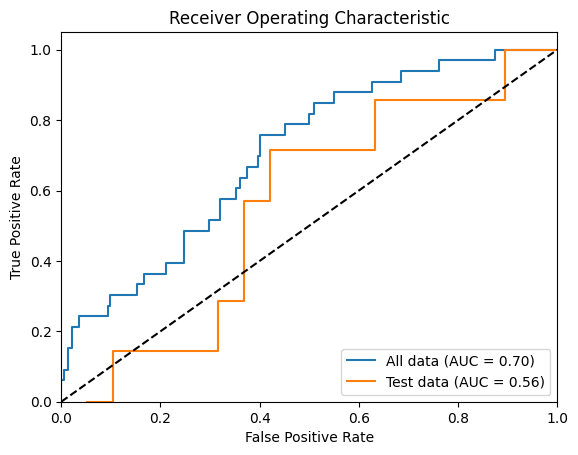

In [64]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_roc(y_true, y_score):
    # Calculate the ROC curve
    fpr, tpr, thresholds = [], [], []
    positive_count = np.sum(y_true)
    negative_count = len(y_true) - positive_count
    sorted_indices = np.argsort(-y_score)
    sorted_true = y_true[sorted_indices]
    sorted_score = y_score[sorted_indices]
    cumulative_positive = np.cumsum(sorted_true)
    cumulative_negative = np.cumsum(~sorted_true)
    fpr = cumulative_negative / negative_count
    tpr = cumulative_positive / positive_count
    thresholds = sorted_score

    # Calculate the AUC
    auc = np.trapz(tpr, fpr)

    return fpr, tpr, auc

# Calculate ROC for all data
y_true_all = np.array(results_df['low_income'] == 'Low income')
y_score_all = np.array(results_df['mean_probability_low_income'])
fpr_all, tpr_all, auc_all = calculate_roc(y_true_all, y_score_all)

# Calculate ROC for test data
results_df_test = results_df[results_df['set_type'] == 'test']
y_true_test = np.array(results_df_test['low_income'] == 'Low income')
y_score_test = np.array(results_df_test['mean_probability_low_income'])
fpr_test, tpr_test, auc_test = calculate_roc(y_true_test, y_score_test)

# Plot the ROC curves
plt.figure()
plt.plot(fpr_all, tpr_all, label='All data (AUC = %0.2f)' % auc_all)
plt.plot(fpr_test, tpr_test, label='Test data (AUC = %0.2f)' % auc_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [65]:
thresholds[0:10]

array([0.307548  , 0.30074668, 0.27758643, 0.2735959 , 0.26803267,
       0.26386458, 0.25753433, 0.2557987 , 0.251483  , 0.2501314 ],
      dtype=float32)

A few interesting insights here, first the thresholds never go about 0.3, but that's because my model has a highest positive predictive value of 0.3, it's only 30% confident that a household is low-income. Second, the AUC is 0.7. Which amazingly is not actually that bad considering this is the most simple model possible. 0.5 is considered no better than random guessing. 

However when calculated just on the test data, the performance is considerably worse. At 0.56 it is not much different from simply guessing.

So, let's try re-running the performance metrics, but with a low decision threshold, 0.15 in this case.

In [66]:
# let's create a function that computes all the metrics
def compute_metrics(y_true, y_score, decision_threshold):
    # Calculate the confusion matrix
    y_pred = y_score > decision_threshold
    TP = sum((y_true == 1) & (y_pred == 1))
    TN = sum((y_true == 0) & (y_pred == 0))
    FP = sum((y_true == 0) & (y_pred == 1))
    FN = sum((y_true == 1) & (y_pred == 0))
    confusion_matrix = pd.DataFrame({'predicted_low_income':[TP, FP], 'predicted_high_income':[FN, TN]}, index=['actual_low_income', 'actual_high_income'])

    # Calculate the recall
    recall = TP / (TP + FN) if TP + FN > 0 else 0

    # Calculate the specificity
    specificity = TN / (TN + FP) if TN + FP > 0 else 0

    # Calculate the precision
    precision = TP / (TP + FP) if TP + FP > 0 else 0

    # Calculate the F1 score
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    # Calculate the accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN) if TP + TN + FP + FN > 0 else 0

    # Calculate the ROC curve
    fpr, tpr, thresholds = [], [], []
    positive_count = np.sum(y_true)
    negative_count = len(y_true) - positive_count
    sorted_indices = np.argsort(-y_score)
    sorted_true = y_true[sorted_indices]
    sorted_score = y_score[sorted_indices]
    cumulative_positive = np.cumsum(sorted_true)
    cumulative_negative = np.cumsum(~sorted_true)
    fpr = cumulative_negative / negative_count if negative_count > 0 else 0
    tpr = cumulative_positive / positive_count if positive_count > 0 else 0
    thresholds = sorted_score

    # Calculate the AUC
    auc = np.trapz(tpr, fpr)

    # calculate the MCC
    mcc = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) if (TP + FP) * (TP + FN) * (TN + FP) * (TN + FN) > 0 else 0

    return confusion_matrix, recall, specificity, precision, f1_score, accuracy, fpr, tpr, thresholds, auc, mcc

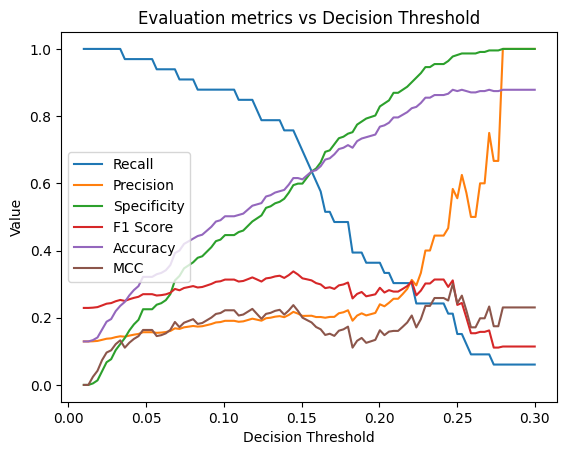

In [67]:
# let's plot out recall and precision and f1_score over a range of decision thresholds from 0.01 to 0.3
decision_thresholds = np.linspace(0.01, 0.3, 100)
recalls = []
precisions = []
specificitys = []
f1_scores = []
accuracies = []
mccs = []
for threshold in decision_thresholds:
    _, recall, specificity, precision, f1_score, accuracy, _, _, _, _, mcc = compute_metrics(y_true, y_score, threshold)
    recalls.append(recall)
    precisions.append(precision)
    specificitys.append(specificity)
    f1_scores.append(f1_score)
    accuracies.append(accuracy)
    mccs.append(mcc)

# now we can plot the recall and precision
plt.figure()
plt.plot(decision_thresholds, recalls, label='Recall')
plt.plot(decision_thresholds, precisions, label='Precision')
plt.plot(decision_thresholds, specificitys, label='Specificity')
plt.plot(decision_thresholds, f1_scores, label='F1 Score')
plt.plot(decision_thresholds, accuracies, label='Accuracy')
plt.plot(decision_thresholds, mccs, label='MCC')
plt.xlabel('Decision Threshold')
plt.ylabel('Value')
plt.title('Evaluation metrics vs Decision Threshold')
plt.legend()
plt.show()


Okay, so what this is showing is that when the decision threshold is very low, basically all cases are marked as positive, which means recall is very high. However specificity is basically zero, and precision is very low. It's a very bad model because everything is labelled as positive, even the cases that are negative.

Then, as the decision thershold is raised, it means we are more and more conservative about flagging a case as positive. As a result the recall inevitably drops. At the extreme, once the threshold is above the maximum confidence level of the model, which is about 30% in this case, then *no* cases are flagged as positive, and recall drops to zero.

Specificity is like recall but for the negative cases. When the decision threshold is at its lowest, all actual negatives are flagged as positive, and the specificity is zero. As the threshold is raised, we are more and more conservative about flagging cases as positive, and this applies to the actual negatives. So the consequence is that the specificity increases. More and more of the actual negative cases are flagged as negative. At the extreme, all cases are flagged as negative, including all actual positive ones. 

There is a threshold value around 0.15 where the recall and specificity are equal. and around 0.6.

Then there's precision. This is saying that of all the predicted true cases, how many are actually true. WHen the decision threshold is at its lowest, the precision is also at its lowest. This is case all cases are flagged positive, and the precision is literally just the proportion of actual positives. Then the decision threshold is raised and we get more conservative in our flagging of positives. We are only flagging as positive those that we are increasingly confident are actually positive. The space keeps shrinking and we get more and more precise. Those that we are flagging are more and more likely to be actually positive. However in doing this we are also throwing out more and more actual positives, i.e. the false negatives are increasing.

The F1 score is then just the harmonic mean of the precision and recall. A threshold that achieves a maximum F1 is one that is striking a balance between maximising precision and recall.

# Model evaluation - income band predictions
## Electricity only

### original results (4 tokens context)
0.002896 M parameters  
set_type
test     0.061124
train    0.168994
Name: accuracy, dtype: float64



### 8 tokens context
0.002896 M parameters
set_type
test     0.110539
train    0.172351
Name: accuracy, dtype: float64


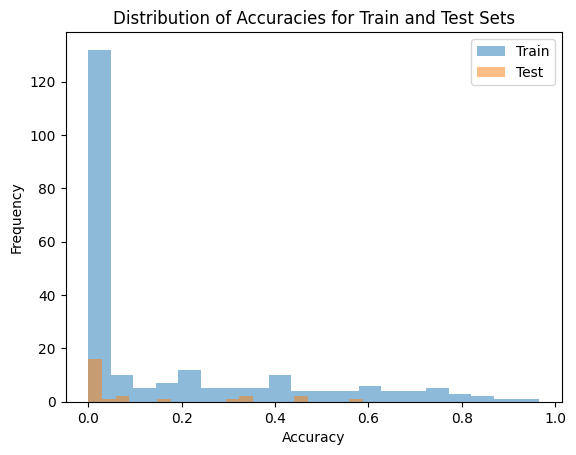

In [57]:
# Get the accuracies for the train and test sets
train_accuracies = results_df[results_df['set_type'] == 'train']['accuracy']
test_accuracies = results_df[results_df['set_type'] == 'test']['accuracy']

# Create a histogram of the train accuracies
plt.hist(train_accuracies, bins=20, alpha=0.5, label='Train')

# Create a histogram of the test accuracies
plt.hist(test_accuracies, bins=20, alpha=0.5, label='Test')

# Add a legend
plt.legend(loc='upper right')

# Add labels and a title
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Distribution of Accuracies for Train and Test Sets')

# Show the plot
plt.show()



### bigger model (16 tokens context)
0.005504 M parameters  
set_type
test     0.071654
train    0.181605
Name: accuracy, dtype: float64


okay, so we can see that just using a bigger model with more context gives a bump in performance. 

### 128 context length 

0.018928 M parameters  
set_type
test     0.089744
train    0.468268
Name: accuracy, dtype: float64

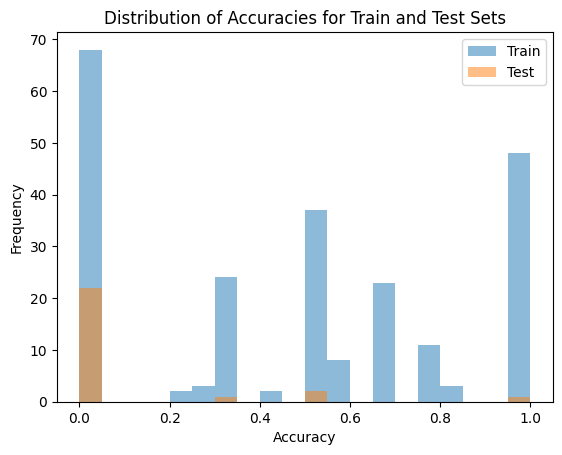

In [52]:


# Get the accuracies for the train and test sets
train_accuracies = results_df[results_df['set_type'] == 'train']['accuracy']
test_accuracies = results_df[results_df['set_type'] == 'test']['accuracy']

# Create a histogram of the train accuracies
plt.hist(train_accuracies, bins=20, alpha=0.5, label='Train')

# Create a histogram of the test accuracies
plt.hist(test_accuracies, bins=20, alpha=0.5, label='Test')

# Add a legend
plt.legend(loc='upper right')

# Add labels and a title
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Distribution of Accuracies for Train and Test Sets')

# Show the plot
plt.show()


Okay, now let's see if we can create a model that gas data, see if it makes a difference.

## Gas data only

In [73]:
model = DecoderModelGas()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss_gas(model=m)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss  {losses['val']:.4f}")

    # sample a batch of data
    xb_gas, yb_income = get_batch_gas('train')

    # evaluate the loss
    logits_income, loss_income = m(xb_gas, yb_income)
    # combine the losses
    optimizer.zero_grad(set_to_none=True)
    loss_income.backward()
    optimizer.step()


0.18408 M parameters
step 0: train loss 2.7725, val loss  2.7803
step 300: train loss 2.1497, val loss  3.2398
step 600: train loss 1.6593, val loss  3.5731
step 900: train loss 1.2977, val loss  4.0450
step 1200: train loss 1.0930, val loss  4.6969
step 1500: train loss 0.9155, val loss  4.9425
step 1800: train loss 0.8052, val loss  5.2022
step 2100: train loss 0.7284, val loss  5.5548
step 2400: train loss 0.6979, val loss  5.5711
step 2700: train loss 0.6310, val loss  5.7631
step 3000: train loss 0.5976, val loss  6.2560
step 3300: train loss 0.5691, val loss  6.0434
step 3600: train loss 0.5602, val loss  6.3159
step 3900: train loss 0.5101, val loss  6.4041
step 4200: train loss 0.5073, val loss  6.1002
step 4500: train loss 0.4943, val loss  6.5439
step 4800: train loss 0.4893, val loss  6.3666
step 4999: train loss 0.4704, val loss  6.2828


### 8 context length
0.020704 M parameters
set_type
test     0.055207
train    0.263775
Name: accuracy, dtype: float64

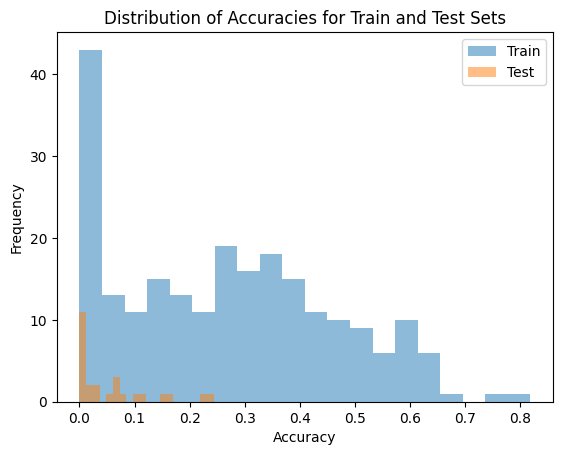

In [65]:
# Initialize a list to store the results
results = []

# Iterate over all unique household ids
for household_id in joined['household_id'].unique():
    # print(household_id)
    # Get the data for the current household
    household_idx = joined[joined['household_id'] == household_id].index
    actual_income = joined.loc[household_idx, 'income_band_cat'].unique()[0]
    data_gas_household = joined.loc[household_idx, 'mean_rounded_gas_pulse'].copy()
    data_gas_household.loc[data_gas_household < 0] = 0
    data_gas_household.loc[data_gas_household > 100000] = np.nan
    data_gas_household = data_gas_household.round(-1)
    data_gas_household = data_gas_household.astype(str).replace('nan', '<M>')
    context_gas = torch.tensor(encode_gas(data_gas_household), dtype=torch.long)
    context_gas = context_gas.unsqueeze(0).to(device)

    # Generate the income band predictions
    income_band_preds = m.generate(context_gas)
    classifications = decode_income(income_band_preds.cpu().numpy().flatten())

    # Calculate the accuracy
    correct_predictions = sum(c == actual_income for c in classifications)
    accuracy = correct_predictions / len(classifications)

    # Check if the household id is in the train or test set
    set_type = 'train' if household_id in train_ids else 'test'

    # Append the results for the current household to the results list
    results.append([household_id, actual_income, accuracy, set_type])

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results, columns=['household_id', 'actual_income', 'accuracy', 'set_type'])

# Get the accuracies for the train and test sets
train_accuracies = results_df[results_df['set_type'] == 'train']['accuracy']
test_accuracies = results_df[results_df['set_type'] == 'test']['accuracy']

# Create a histogram of the train accuracies
plt.hist(train_accuracies, bins=20, alpha=0.5, label='Train')

# Create a histogram of the test accuracies
plt.hist(test_accuracies, bins=20, alpha=0.5, label='Test')

# Add a legend
plt.legend(loc='upper right')

# Add labels and a title
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Distribution of Accuracies for Train and Test Sets')

# Show the plot
plt.show()

### 16 context


0.02344 M parameters


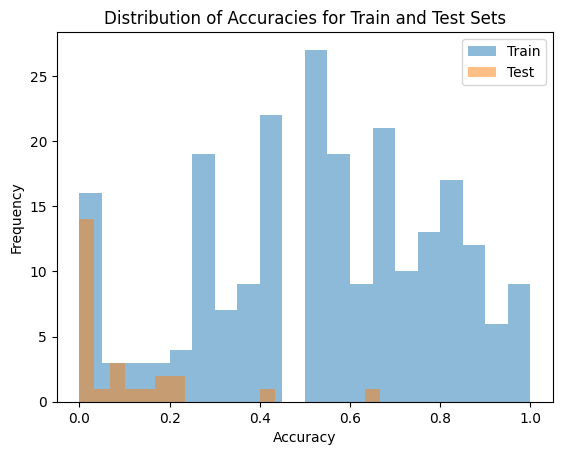

In [70]:
# Initialize a list to store the results
results = []

# Iterate over all unique household ids
for household_id in joined['household_id'].unique():
    # print(household_id)
    # Get the data for the current household
    household_idx = joined[joined['household_id'] == household_id].index
    actual_income = joined.loc[household_idx, 'income_band_cat'].unique()[0]
    data_gas_household = joined.loc[household_idx, 'mean_rounded_gas_pulse'].copy()
    data_gas_household.loc[data_gas_household < 0] = 0
    data_gas_household.loc[data_gas_household > 100000] = np.nan
    data_gas_household = data_gas_household.round(-1)
    data_gas_household = data_gas_household.astype(str).replace('nan', '<M>')
    context_gas = torch.tensor(encode_gas(data_gas_household), dtype=torch.long)
    context_gas = context_gas.unsqueeze(0).to(device)

    # Generate the income band predictions
    income_band_preds = m.generate(context_gas)
    classifications = decode_income(income_band_preds.cpu().numpy().flatten())

    # Calculate the accuracy
    correct_predictions = sum(c == actual_income for c in classifications)
    accuracy = correct_predictions / len(classifications)

    # Check if the household id is in the train or test set
    set_type = 'train' if household_id in train_ids else 'test'

    # Append the results for the current household to the results list
    results.append([household_id, actual_income, accuracy, set_type])

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results, columns=['household_id', 'actual_income', 'accuracy', 'set_type'])
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
print(results_df.groupby('set_type')['accuracy'].mean())
# Get the accuracies for the train and test sets
train_accuracies = results_df[results_df['set_type'] == 'train']['accuracy']
test_accuracies = results_df[results_df['set_type'] == 'test']['accuracy']

# Create a histogram of the train accuracies
plt.hist(train_accuracies, bins=20, alpha=0.5, label='Train')

# Create a histogram of the test accuracies
plt.hist(test_accuracies, bins=20, alpha=0.5, label='Test')

# Add a legend
plt.legend(loc='upper right')

# Add labels and a title
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Distribution of Accuracies for Train and Test Sets')

# Show the plot
plt.show()

In [71]:
print(results_df.groupby('set_type')['accuracy'].mean())

set_type
test     0.092285
train    0.534260
Name: accuracy, dtype: float64


### 128 context

0.18408 M parameters
set_type
test     0.025641
train    0.843450
Name: accuracy, dtype: float64


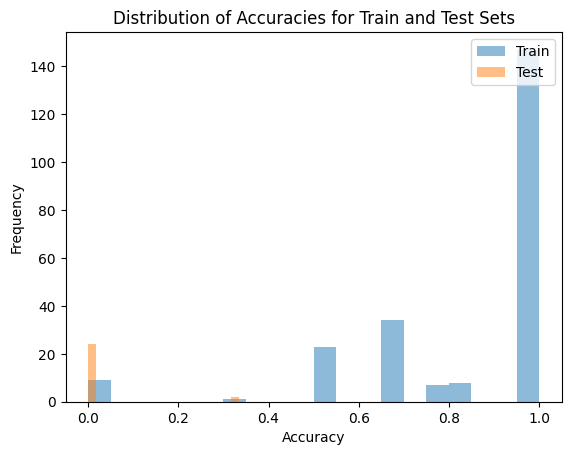

In [74]:
# Initialize a list to store the results
results = []

# Iterate over all unique household ids
for household_id in joined['household_id'].unique():
    # print(household_id)
    # Get the data for the current household
    household_idx = joined[joined['household_id'] == household_id].index
    actual_income = joined.loc[household_idx, 'income_band_cat'].unique()[0]
    data_gas_household = joined.loc[household_idx, 'mean_rounded_gas_pulse'].copy()
    data_gas_household.loc[data_gas_household < 0] = 0
    data_gas_household.loc[data_gas_household > 100000] = np.nan
    data_gas_household = data_gas_household.round(-1)
    data_gas_household = data_gas_household.astype(str).replace('nan', '<M>')
    context_gas = torch.tensor(encode_gas(data_gas_household), dtype=torch.long)
    context_gas = context_gas.unsqueeze(0).to(device)

    # Generate the income band predictions
    income_band_preds = m.generate(context_gas)
    classifications = decode_income(income_band_preds.cpu().numpy().flatten())

    # Calculate the accuracy
    correct_predictions = sum(c == actual_income for c in classifications)
    accuracy = correct_predictions / len(classifications)

    # Check if the household id is in the train or test set
    set_type = 'train' if household_id in train_ids else 'test'

    # Append the results for the current household to the results list
    results.append([household_id, actual_income, accuracy, set_type])

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results, columns=['household_id', 'actual_income', 'accuracy', 'set_type'])
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
print(results_df.groupby('set_type')['accuracy'].mean())
# Get the accuracies for the train and test sets
train_accuracies = results_df[results_df['set_type'] == 'train']['accuracy']
test_accuracies = results_df[results_df['set_type'] == 'test']['accuracy']

# Create a histogram of the train accuracies
plt.hist(train_accuracies, bins=20, alpha=0.5, label='Train')

# Create a histogram of the test accuracies
plt.hist(test_accuracies, bins=20, alpha=0.5, label='Test')

# Add a legend
plt.legend(loc='upper right')

# Add labels and a title
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Distribution of Accuracies for Train and Test Sets')

# Show the plot
plt.show()